<a href="https://colab.research.google.com/github/ttsuneoka/GoogleColab/blob/master/chapter8_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# data read
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content

mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

In [ ]:
mushroom.columns = ['classes','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment', 'gill-spacing', 'gill-size','gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring','stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

mushroom.head()

,classes,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
print('data stype:{}'.format(mushroom.shape))
print('missing number:{}'.format(mushroom.isnull().sum().sum()))

data stype:(8124, 23)
missing number:0


In [ ]:
# dummy variable
mushroom_dummy = pd.get_dummies(mushroom[['gill-color', 'gill-attachment', 'odor', 'cap-color']])
mushroom_dummy.head()

,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,gill-attachment_a,gill-attachment_f,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
mushroom_dummy['flg'] = mushroom['classes'].map(lambda x:1 if x == 'p' else 0)

In [ ]:
mushroom_dummy['flg']

0       1
1       0
2       0
3       1
4       0
       ..
8119    0
8120    0
8121    0
8122    1
8123    0
Name: flg, Length: 8124, dtype: int64

In [ ]:
mushroom_dummy.groupby(['cap-color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap-color_c,,
0,4176,3904
1,32,12


In [ ]:
mushroom_dummy.groupby(['gill-color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill-color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [ ]:
# entropy (50% - 50%) -> not indentified
-(0.5 * np.log2(0.5) + 0.5 * np.log2(0.5))

1.0

In [ ]:
# entropy (0.1% - 99.9%) -> identified
-(0.001 * np.log2(0.001) + 0.999 * np.log2(0.999))

0.011407757737461138

In [ ]:
def calc_entropy(p):
    return -(p * np.log2(p) + (1-p) * np.log2(1-p))

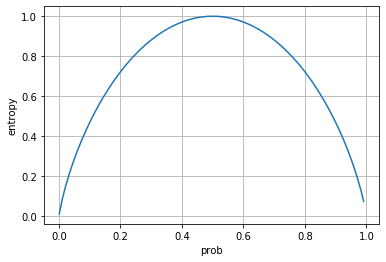

In [ ]:
#  p-value : 0.001 - 0.999 ; 0.01 pitch
p = np.arange(0.001, 0.999, 0.01)

plt.plot(p, calc_entropy(p))
plt.xlabel('prob')
plt.ylabel('entropy')
plt.grid(True)

In [ ]:
mushroom_dummy.groupby('flg')['flg'].count()

flg
0    4208
1    3916
Name: flg, dtype: int64

In [ ]:
p = 4208/(4208+3916)
entropy_init = -( p * np.log2(p) + (1-p) * np.log2(1-p))
print('initial entropy: {:.3f}'.format(entropy_init))

initial entropy: 0.999


In [ ]:
mushroom_dummy.groupby(['cap-color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap-color_c,,
0,4176,3904
1,32,12


In [ ]:
# entropy of not cap-color_c
p1 = 4176 / (4176 + 3904)
p2 = 1 - p1
entropy_c0 = -(p1 * np.log2(p1) + p2 * np.log2(p2))
print('entropy_c0: {:.3f}'.format(entropy_c0))

entropy_c0: 0.999


In [ ]:
# entropy of cap-color_c
p1 = 32 / (32 + 12)
p2 = 1 - p1
entropy_c1 = -(p1 * np.log2(p1) + p2 * np.log2(p2))
print('entropy_c0: {:.3f}'.format(entropy_c1))

entropy_c0: 0.845


In [ ]:
entropy_after = (4176+3904)/(4176+3904+32+12) * entropy_c0 + (32+12)/(4176+3904+32+12) * entropy_c1
print('Average entropy after data division: {:.3f}'.format(entropy_after))

Average entropy after data division: 0.998


In [ ]:
print('Information gain by cap-color data division: {:.3f}'.format(entropy_init - entropy_after))

Information gain by cap-color data division: 0.001


In [ ]:
mushroom_dummy.groupby(['gill-color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill-color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [ ]:
# entropy of not gill-color_b
p1 = 4208/(4208+2188)
p2 = 1 - p1
entropy_b0 = -(p1 * np.log2(p1) + p2 * np.log2(p2))

# entropy of gill-color_b
p1 = 0/(0+1728)
p2 = 1 - p1
entropy_b1 = -(p2 * np.log2(p2))

entropy_after = (4208+2188)/(4208+2188+0+1728) * entropy_b0 + (0+1728)/(4208+2188+0+1728) * entropy_b1
print('Information gain by gill-color data divition: {:.3f}'.format(entropy_init - entropy_after))

Information gain by gill-color data divition: 0.269


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# data division
X = mushroom_dummy.drop('flg', axis=1)
y = mushroom_dummy['flg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# decision tree
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
model.fit(X_train, y_train)

print('Accuracy rate(train): {:.3f}'.format(model.score(X_train, y_train)))
print('Accuracy rate(test) : {:.3f}'.format(model.score(X_test, y_test)))

Accuracy rate(train): 0.991
Accuracy rate(test) : 0.992


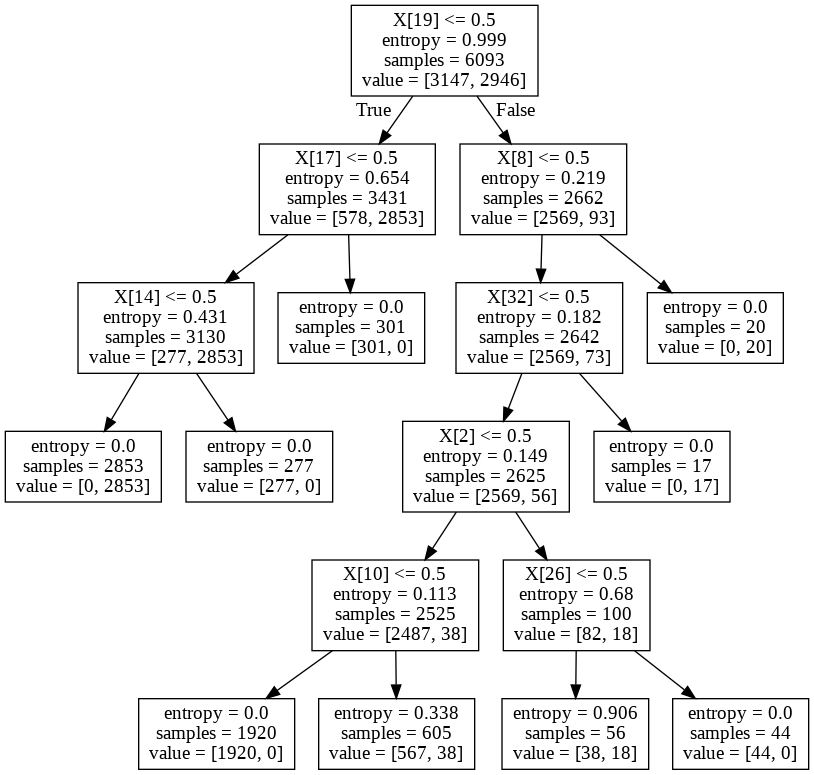

In [ ]:
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())